In [7]:
import numpy as np
import networkx as nx
from dotmotif import Motif, GrandIsoExecutor
import matplotlib.pyplot as plt
from scipy.stats import ranksums
from lsmm_data import LSMMData
import json
from tqdm import tqdm
import scipy.stats as stats

with open('pyr_rect.json') as f:
    loaded_json = json.load(f)
my_data = LSMMData.LSMMData(loaded_json)
data_a = my_data.data
params_a = my_data.params
dirs_a = my_data.dirs
mappings_a = my_data.mappings

import pickle

with open('trevor_data_a.pkl', 'wb') as f:
    pickle.dump(data_a, f)

with open('trevor_params_a.pkl', 'wb') as f:
    pickle.dump(params_a, f)

with open('trevor_dirs_a.pkl', 'wb') as f:
    pickle.dump(dirs_a, f)

with open('trevor_mappings_a.pkl', 'wb') as f:
    pickle.dump(mappings_a, f)

# Generate the chain results

# Make a graph
cell_table = data_a['structural']['pre_cell'].copy()
cell_table['connectome_index'] = cell_table.index
synapse_table = data_a['structural']['synapse']
adjacency_matrix = data_a['structural']['binary_connectome']
pyr_graph = nx.DiGraph()

# # Add edges to the graph
# rows, cols = data_a['structural']['binary_connectome'].shape
# for i in range(rows):
#     for j in range(cols):
#         if data_a['structural']['binary_connectome'][i, j] != 0:  # 0 means no edge
#             pyr_graph.add_edge(i, j, weight=data_a['structural']['binary_connectome'][i, j])

# Add edges to the graph
rows, cols = data_a['structural']['binary_connectome'].shape
for i in range(rows):
    for j in range(cols):
        if data_a['structural']['binary_connectome'][i, j] != 0:  # 0 means no edge
            pyr_graph.add_edge(f'pre_{i}', f'post_{j}', weight=data_a['structural']['binary_connectome'][i, j])

## Uncomment below to load existing chain motif analysis results
# two_chain_results_array = np.load('all_cell_two_chain_results_array.npy')
# three_chain_results_array = np.load('all_cell_three_chain_results_array.npy')
# four_chain_results_array = np.load('all_cell_four_chain_results_array.npy')

# Or uncomment below to generate new motif analysis results (Can take quite a while on larger graphs)
# Motif Analysis with DotMotif: 2 Chain, All Pyr
executor = GrandIsoExecutor(graph=pyr_graph)
chain_defs = Motif("""
                A -> B
              """)

chain_results = executor.find(chain_defs)

two_chain_results_array = np.array([list(c.values()) for c in tqdm(chain_results)])
removed_pre_post_strings = np.zeros_like(two_chain_results_array)
for i, c in enumerate(chain_results):
    for j, n in enumerate(c.values()):
        removed_pre_post_strings[i, j] = int(n.split('_')[1])

two_chain_results_array = np.array(removed_pre_post_strings).astype(int)

# two_chain_results_array = np.array([list(c.values()) for c in tqdm(chain_results)])

assembly_chain_results_arrays = [two_chain_results_array]

chain_count_string_array = ['pyr_cell_2chain']
individual_assembly_indexes = [mappings_a['connectome_indexes_by_assembly'][f'A {i}'] for i in range(1,16)]
individual_post_assembly_indexes = [mappings_a['post_connectome_indexes_by_assembly'][f'A {i}'] for i in range(1,16)]

coregistered_post_cell_indexes = mappings_a['assemblies_by_post_connectome_index'].keys()
coregistered_cell_indexes = mappings_a['assemblies_by_connectome_index'].keys()
no_a_cell_indexes = mappings_a['connectome_indexes_by_assembly']['No A']
no_a_post_cell_indexes = mappings_a['post_connectome_indexes_by_assembly']['No A']
pooled_assembly_indexes = [list(set(coregistered_cell_indexes) - set(no_a_cell_indexes))]
pooled_assembly_post_indexes = [list(set(coregistered_post_cell_indexes) - set(no_a_post_cell_indexes))]


Generating Connectome...


100%|██████████| 813407/813407 [08:08<00:00, 1664.90it/s]


Generating Connectome...


100%|██████████| 813407/813407 [11:00<00:00, 1231.31it/s]
373158it [00:24, 15152.91it/s]
100%|██████████| 373158/373158 [00:01<00:00, 225456.78it/s]


## Intra-Assembly vs No Assembly

Pooled Intra-assembly Connections: 49 out of 1608 possible
6714.0
	 6714.0
506.0
	 506.0
1476.0
1369.0
	 2845.0
4441.0
	 4441.0
3617.0
	 3617.0
357.0
	 357.0
2213.0
	 2213.0
No A: 8 out of 396 possible
55 x 114
A-A vs A-No A
RanksumsResult(statistic=0.04594768006447692, pvalue=0.48167597554340214)
A Cells Outbound vs No A Cells Outbound
RanksumsResult(statistic=0.3914614977689143, pvalue=0.34772807143883583)
Medians 0.0 0.0
Nonzero A Cells Outbound vs No A Cells Outbound
RanksumsResult(statistic=2.1712405933672376, pvalue=0.014956495160387974)


Text(0.5, 1.0, 'SUMMED PSD: Nonzero Intra-assembly CELLS vs No A')

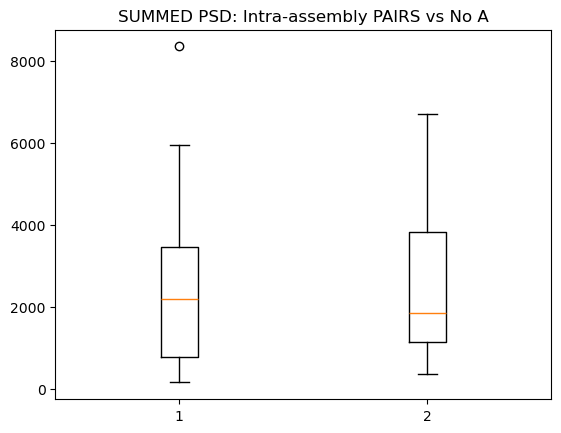

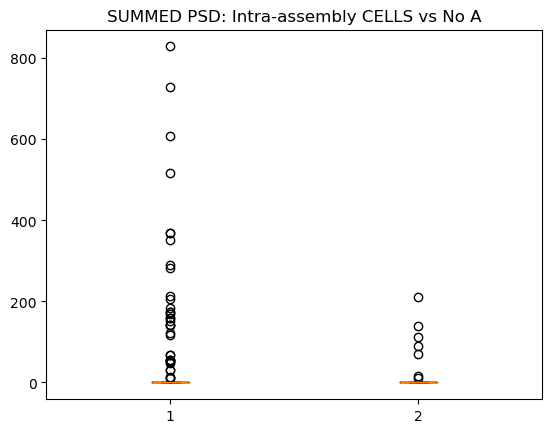

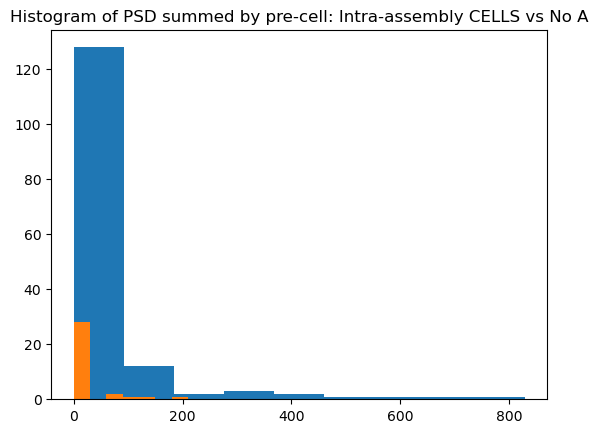

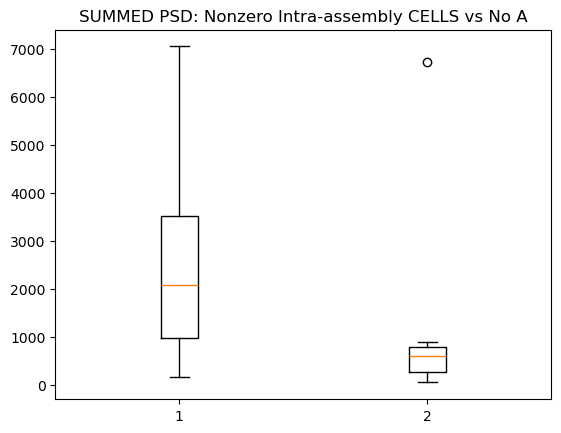

In [17]:
zero_counts = 0
connections = 0
summed_psd_sizes = []
summed_a_cell_outbound_sizes = []
nonzero_summed_a_cell_outbound_sizes = []
for ai in range(len(individual_assembly_indexes)):
    for pp in individual_post_assembly_indexes[ai]:
        temp_sum = 0
        per_assembly_connections = 0
        if len(individual_post_assembly_indexes[ai]) > 1:
            for pi in individual_assembly_indexes[ai]:
                if len(two_chain_results_array[np.where(np.logical_and(two_chain_results_array[:,0] == pi, two_chain_results_array[:,-1] == pp))]) > 0:
                    temp = data_a['structural']['summed_size_connectome'][pi, pp] #/ (len(individual_assembly_indexes[ai]) * (len(individual_post_assembly_indexes[ai])-1))
                    summed_psd_sizes.append(temp)
                    temp_sum += temp
                    connections += 1
                    per_assembly_connections += 1
                else:
                    zero_counts += 1
            if temp_sum > 0:
                nonzero_summed_a_cell_outbound_sizes.append(temp_sum / per_assembly_connections)
            summed_a_cell_outbound_sizes.append(temp_sum / (len(individual_post_assembly_indexes[ai]) - 1))
print(f'Pooled Intra-assembly Connections: {connections} out of {zero_counts + connections} possible')

zero_counts = 0
connections = 0
summed_no_a_psd_sizes = []
summed_no_a_cell_outbound_sizes = []
nonzero_summed_no_a_cell_outbound_sizes = []
for pp in no_a_post_cell_indexes:
    temp_sum = 0
    for pi in no_a_cell_indexes:
        if len(two_chain_results_array[np.where(np.logical_and(two_chain_results_array[:,0] == pi, two_chain_results_array[:,-1] == pp))]) > 0:
            temp = data_a['structural']['summed_size_connectome'][pi, pp] #/ (len(no_a_cell_indexes) * (len(no_a_post_cell_indexes)-1))
            summed_no_a_psd_sizes.append(temp)
            temp_sum += temp
            print(temp)
            connections += 1
        else:
            zero_counts += 1
    if temp_sum > 0:
        print("\t", temp_sum)
        nonzero_summed_no_a_cell_outbound_sizes.append(temp_sum / connections)
    summed_no_a_cell_outbound_sizes.append(temp_sum / (len(no_a_post_cell_indexes) - 1))
print(f'No A: {connections} out of {zero_counts + connections} possible')

# print('Assembly Root IDs:', list(set(mappings_a['assemblies_by_pt_root_id'].keys()) - set(mappings_a['pt_root_ids_by_assembly']['No A'])))
# print('NonAssembly Root IDs:', mappings_a['pt_root_ids_by_assembly']['No A'])
print(f'{len(coregistered_cell_indexes)} x {len(coregistered_post_cell_indexes)}')

print('A-A vs A-No A')
print(stats.ranksums(summed_psd_sizes, summed_no_a_psd_sizes, alternative='greater'))

plt.figure()
plt.boxplot([summed_psd_sizes, summed_no_a_psd_sizes])
plt.title('SUMMED PSD: Intra-assembly PAIRS vs No A')

print('A Cells Outbound vs No A Cells Outbound')
print(stats.ranksums(summed_a_cell_outbound_sizes, summed_no_a_cell_outbound_sizes, alternative='greater'))
# print(stats.ttest_ind(summed_a_cell_outbound_sizes, summed_no_a_cell_outbound_sizes, equal_var=False))
plt.figure()
plt.boxplot([summed_a_cell_outbound_sizes, summed_no_a_cell_outbound_sizes])
plt.title('SUMMED PSD: Intra-assembly CELLS vs No A')
print("Medians", np.median(summed_a_cell_outbound_sizes), np.median(summed_no_a_cell_outbound_sizes))

plt.figure()
plt.hist(summed_a_cell_outbound_sizes, bins='auto')
plt.hist(summed_no_a_cell_outbound_sizes, bins='auto')
plt.title('Histogram of PSD summed by pre-cell: Intra-assembly CELLS vs No A')

print('Nonzero A Cells Outbound vs No A Cells Outbound')
print(stats.ranksums(nonzero_summed_a_cell_outbound_sizes, nonzero_summed_no_a_cell_outbound_sizes, alternative='greater'))
plt.figure()
plt.boxplot([nonzero_summed_a_cell_outbound_sizes, nonzero_summed_no_a_cell_outbound_sizes])
plt.title('SUMMED PSD: Nonzero Intra-assembly CELLS vs No A')


# print(len(data_a['structural']['pre_cell']))
# print(len(data_a['structural']['synapse']))
# print(len(data_a['structural']['post_cell']))
    

## Intra-Assembly vs Inter-Assembly

Pooled Intra-assembly Connections: 49 out of 1608 possible
Pooled Inter-assembly Connections: 378 out of 12160 possible
55 x 114
A Cells Outbound vs Inter-assembly Cells Outbound
RanksumsResult(statistic=2.4974491056318464, pvalue=0.00625452099579468)
Medians 0.0 0.0
Means 81.23046146144408 40.22467404019018


Text(0.5, 1.0, 'Histogram of PSD summed by pre-cell: Intra-assembly CELLS vs Inter-assembly')

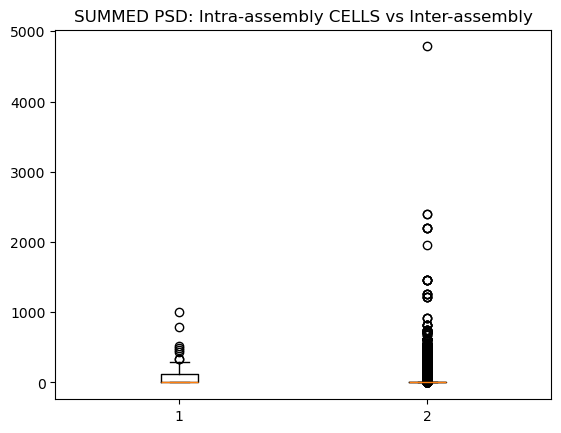

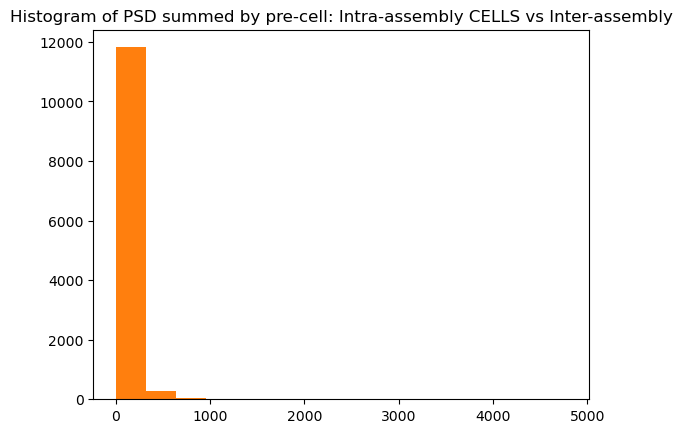

In [33]:
zero_counts = 0
connections = 0
summed_psd_sizes = []
summed_a_cell_outbound_sizes = []
nonzero_summed_a_cell_outbound_sizes = []
for ai in range(len(individual_assembly_indexes)):
    for pre_cell in individual_assembly_indexes[ai]:
        temp_sum = 0
        per_assembly_connections = 0
        if len(individual_post_assembly_indexes[ai]) > 1:
            for post_cell in individual_post_assembly_indexes[ai]:
                if len(two_chain_results_array[np.where(np.logical_and(two_chain_results_array[:,0] == pre_cell, two_chain_results_array[:,-1] == post_cell))]) > 0:
                    temp = data_a['structural']['summed_size_connectome'][pre_cell, post_cell] #/ (len(individual_assembly_indexes[ai]) * (len(individual_post_assembly_indexes[ai])-1))
                    summed_psd_sizes.append(temp)
                    temp_sum += temp
                    connections += 1
                    per_assembly_connections += 1
                else:
                    zero_counts += 1
            if temp_sum > 0:
                nonzero_summed_a_cell_outbound_sizes.append(temp_sum / per_assembly_connections)
            summed_a_cell_outbound_sizes.append(temp_sum / (len(individual_post_assembly_indexes[ai]) - 1))
print(f'Pooled Intra-assembly Connections: {connections} out of {zero_counts + connections} possible')

zero_counts = 0
connections = 0
summed_no_a_psd_sizes = []
summed_no_a_cell_outbound_sizes = []
nonzero_summed_no_a_cell_outbound_sizes = []
for pre_a in range(len(individual_assembly_indexes)):
    for post_a in range(len(individual_assembly_indexes)):
        unique_post_indexes = list(set(individual_post_assembly_indexes[post_a]) - set(individual_assembly_indexes[pre_a]))
        if pre_a != post_a:
            for pre_cell in individual_assembly_indexes[pre_a]:
                temp_sum = 0
                per_assembly_connections = 0
                if len(unique_post_indexes) > 0:
                    for post_cell in unique_post_indexes:
                        # print(pre_cell, post_cell)
                        if len(two_chain_results_array[np.where(np.logical_and(two_chain_results_array[:,0] == pre_cell, two_chain_results_array[:,-1] == post_cell))]) > 0:
                            temp = data_a['structural']['summed_size_connectome'][pre_cell, post_cell] 
                            summed_psd_sizes.append(temp)
                            temp_sum += temp
                            connections += 1
                            per_assembly_connections += 1
                        else:
                            zero_counts += 1
                        if temp_sum > 0:
                            nonzero_summed_no_a_cell_outbound_sizes.append(temp_sum / per_assembly_connections)
                        # print(pre_cell, post_cell, temp_sum, temp_sum / len(unique_post_indexes))
                        summed_no_a_cell_outbound_sizes.append(temp_sum / len(unique_post_indexes))
print(f'Pooled Inter-assembly Connections: {connections} out of {zero_counts + connections} possible')

# print('Assembly Root IDs:', list(set(mapost_cellre_cellngs_a['assemblies_by_pt_root_id'].keys()) - set(mapost_cellre_cellngs_a['pt_root_ids_by_assembly']['No A'])))
# print('NonAssembly Root IDs:', mapost_cellre_cellngs_a['pt_root_ids_by_assembly']['No A'])
print(f'{len(coregistered_cell_indexes)} x {len(coregistered_post_cell_indexes)}')

# print('Intra-assembly vs Inter-assembly PAIRS')
# print(stats.ranksums(summed_psd_sizes, summed_no_a_psd_sizes, alternative='greater'))
# plt.figure()
# plt.boxplot([summed_psd_sizes, summed_no_a_psd_sizes])
# plt.title('SUMMED PSD: Intra-assembly PAIRS vs Inter-assembly')

print('A Cells Outbound vs Inter-assembly Cells Outbound')
print(stats.ranksums(summed_a_cell_outbound_sizes, summed_no_a_cell_outbound_sizes, alternative='greater'))
plt.figure()
plt.boxplot([summed_a_cell_outbound_sizes, summed_no_a_cell_outbound_sizes])
plt.title('SUMMED PSD: Intra-assembly CELLS vs Inter-assembly')
print("Medians", np.median(summed_a_cell_outbound_sizes), np.median(summed_no_a_cell_outbound_sizes))
print("Means", np.mean(summed_a_cell_outbound_sizes), np.mean(summed_no_a_cell_outbound_sizes))

plt.figure()
plt.hist(summed_a_cell_outbound_sizes, bins='100')
plt.hist(summed_no_a_cell_outbound_sizes, bins='100')
plt.title('Histogram of PSD summed by pre-cell: Intra-assembly CELLS vs Inter-assembly')

# print('Nonzero Intra-Assembly Cells Outbound vs Inter-assembly Cells Outbound')
# print(stats.ranksums(nonzero_summed_a_cell_outbound_sizes, nonzero_summed_no_a_cell_outbound_sizes, alternative='greater'))
# plt.figure()
# plt.boxplot([nonzero_summed_a_cell_outbound_sizes, nonzero_summed_no_a_cell_outbound_sizes])
# plt.title('SUMMED PSD: Nonzero Intra-assembly CELLS vs Inter-assembly')


# print(len(data_a['structural']['pre_cell']))
# print(len(data_a['structural']['synapse']))
# print(len(data_a['structural']['post_cell']))
    